In [1]:
import pandas as pd
import numpy as np

In [2]:
titanic = pd.read_csv("data/train.csv")

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Data Inspection

Special features need attention:

- Survived: the label
- Name: drop
- Ticket: drop
- Cabin: Too few data, drop
- Sex: convert to binary label
- Embarked: One-hot vector
- Impute: Age, Embarked

In [5]:
titanic_features = titanic.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
titanic_labels = titanic_features['Survived']
titanic_features.drop(columns=['Survived'], inplace=True)
titanic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


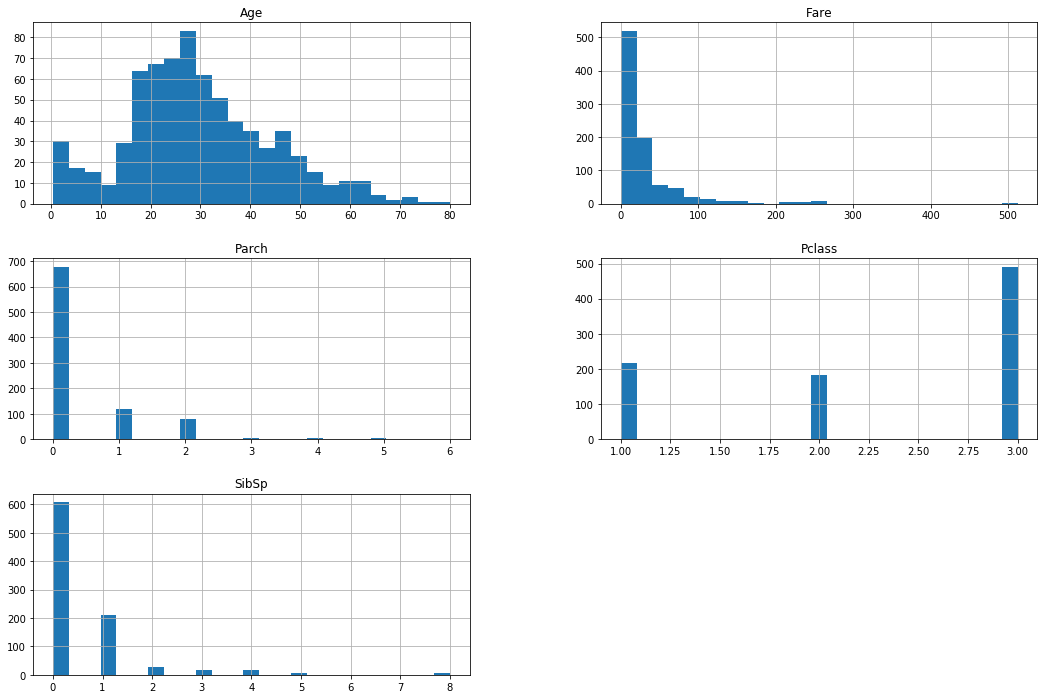

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
titanic_features.hist(bins=25,figsize=(18,12))
plt.show()

# Data Cleaning

In [7]:
cols_num = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cols_cat = ['Embarked']
cols_bin = ['Sex']

Integrate feature selection into the pipeline.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X:'DataFrame') -> 'np.array':
        return X[self.feature_names].values
        # same:
        # return X.loc[:, self.feature_names].values

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

pipe_num = Pipeline([
    ('feature_selector', FeatureSelector(cols_num)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
pipe_cat = Pipeline([
    ('feature_selector', FeatureSelector(cols_cat)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder()),    
])
pipe_bin = Pipeline([
    ('feature_selector', FeatureSelector(cols_bin)),
    # No imputer
    ('binarizer', OrdinalEncoder()),
])

pipe_full = FeatureUnion([
    ('pipe_num', pipe_num),
    ('pipe_cat', pipe_cat),
    ('pipe_bin', pipe_bin),
])

feature_prepared = pipe_full.fit_transform(titanic_features)

# Train on ML methods

In [16]:
# Linear Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.8, penalty='l2', solver='liblinear')

log_reg.fit(feature_prepared, titanic_labels)
model = log_reg

# Evaluation (Cross-Validation)

In [17]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, feature_prepared, titanic_labels, cv=4, return_train_score=True)
for i in range(cv_results['fit_time'].shape[0]):
    print("CV {:1d}. Training score {:.3f}, testing score: {:.3f}".format(i,cv_results['train_score'][i],cv_results['test_score'][i]))
print("Average test score (probability): {:.3f}".format(np.mean(cv_results['test_score'])))

CV 0. Training score 0.810, testing score: 0.781
CV 1. Training score 0.795, testing score: 0.812
CV 2. Training score 0.812, testing score: 0.770
CV 3. Training score 0.800, testing score: 0.820
Average test score (probability): 0.796


# Tuning (Grid Search)

Parameters for Logistic Regression

In [104]:
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [146]:
param_grid = [
    {'solver':['liblinear'], 'penalty':['l1', 'l2'], 'C':[0.5, 0.7, 0.8, 0.9, 1, 1.5]},
    {'solver':['lbfgs'], 'penalty':['l2'], 'C':[0.5, 1, 1.5]},
]

In [147]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(model, param_grid, cv=4)
grid_search.fit(feature_prepared, titanic_labels)

print("Accuracy of all param combination:", grid_search.cv_results_['mean_test_score'])
print("Best paramter:", grid_search.best_params_)
print("Best test score:", grid_search.best_score_)

Accuracy of all param combination: [0.78787879 0.79236813 0.78787879 0.79461279 0.78900112 0.79573513
 0.78675645 0.79573513 0.78675645 0.79573513 0.78900112 0.79349046
 0.79461279 0.79349046 0.79349046]
Best paramter: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}
Best test score: 0.7957351290684624


# Output

In [25]:
test = pd.read_csv("data/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
test_prepared = pipe_full.transform(test)
pred = model.predict(test_prepared)

In [42]:
output = pd.concat([test["PassengerId"], pd.Series(pred, name='Survived')],axis=1)
print(output.head())
output.to_csv("output/prediction_result.csv",index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
